![image.png](https://i.imgur.com/a3uAqnb.png)

## Pre-trained CNN with VGG for Image Classification

This exercise demonstrates how to use a pre-trained VGG model for image classification on the CIFAR-10 dataset using PyTorch. We will leverage transfer learning by modifying the final layers of the VGG network to classify images into 10 categories.

### Dependencies

First, let's install and import the necessary libraries.

In [ ]:
import #To-Do: import 

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 1️⃣ Dataset Class

We'll use `torchvision.datasets.CIFAR10` directly, as it's a standard dataset with built-in functionalities. We'll define transformations for data augmentation and normalization, and then create `DataLoader` instances for training and testing.

In [ ]:
# Define transformations for the training and test sets
transform_train = transforms.Compose([
    ## To-Do
])

transform_test = transforms.Compose([

    ## To-Do
])

# Load CIFAR-10 datasets
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = # To-Do, what classes do we have? :)
print(f"Number of training samples: {len(trainset)}")
print(f"Number of test samples: {len(testset)}")

Number of training samples: 50000
Number of test samples: 10000


#### Let's display some images

It's always good practice to visualize some of the data to ensure it's loaded correctly.

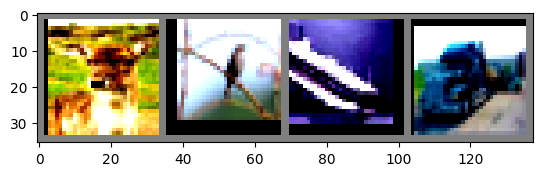

deer  bird  ship  truck


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize, but why?
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = #To-Do: get an iterator from trainloader
images, labels = #To-Do: get next batch from the iterator

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### 2️⃣ Model Class

We will use a pre-trained VGG-16 model from `torchvision.models`. We'll freeze the feature extraction layers and replace the classifier head to adapt it for CIFAR-10's 10 classes.

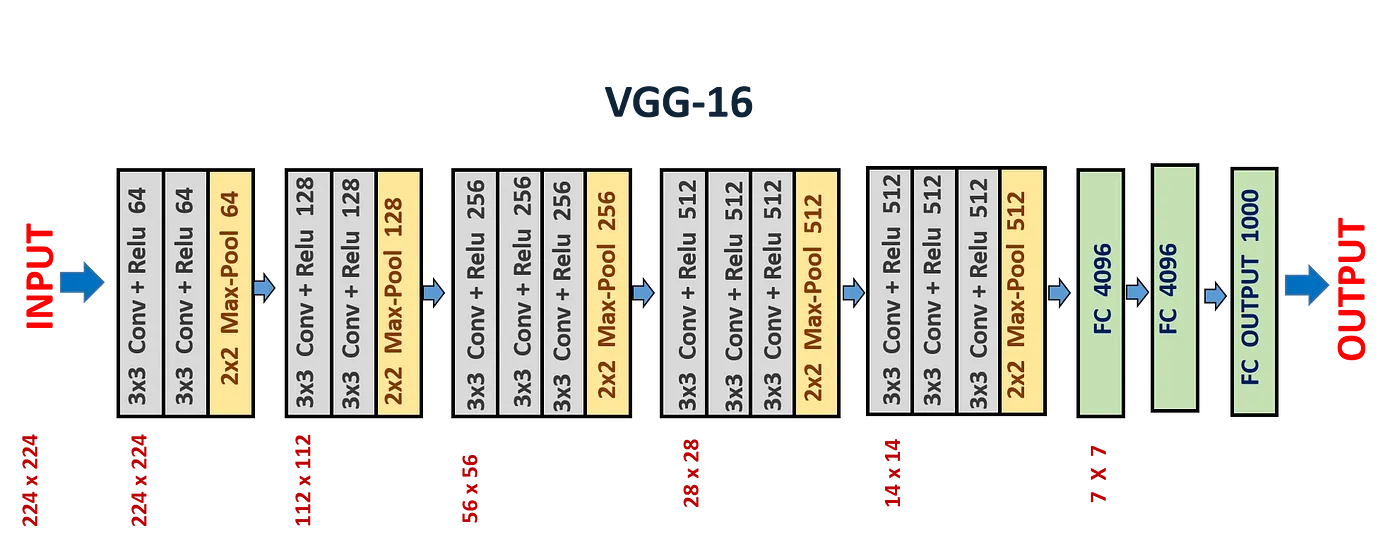

In [ ]:
class VGG16_CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16_CIFAR10, self).__init__()
        # Load pre-trained VGG16 model
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # Freeze all parameters in the feature extractor
        for param in vgg16.features.parameters():
            param.requires_grad = False

        self.features = vgg16.features

        # Replace the classifier with a new one for CIFAR-10
        # VGG16's original classifier expects input features from avgpool of size 512*7*7 (for 224x224 input)
        # For 32x32 input, after features, the size will be smaller. Let's adapt.
        # Example: For 32x32 input, after VGG features, output size is usually 512 * 1 * 1 for VGG-16.
        # We need to flatten this to 512.

        # A common practice is to calculate the output size of features layer with a dummy tensor
        # dummy_input = torch.randn(1, 3, 32, 32)
        # output_features = self.features(dummy_input)
        # num_features = output_features.view(output_features.size(0), -1).size(1)
        # print(f"Number of features from VGG16 features for 32x32 input: {num_features}")
        # For VGG16 on 32x32, it's typically 512 (after features and AdaptiveAvgPool2d)

        self.classifier = nn.Sequential(
            nn.Linear(## * ## * ##,
                      4096), # Assuming features output 512x1x1 for 32x32 input
            nn.##(True),
            nn.Dropout(),
            nn.Linear(##, ##),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(##, num_classes)
        )

        # To handle potential variations in feature map size, we can use AdaptiveAvgPool2d
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.classifier(x)
        return x

model = #To-Do: Instantiate the model
# we move the model to?
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 106MB/s] 


VGG16_CIFAR10(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### 3️⃣ Training and Validation Loops

We will define functions for a single training epoch and a single validation epoch. The training loop involves forward pass, loss calculation, backward pass, and optimizer step. The validation loop only performs a forward pass and loss calculation to evaluate performance on unseen data.

In [ ]:
criterion = # To-Do: Define the loss function, Clasfication task!
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

def train_epoch(model, dataloader, criterion, optimizer, device):
#To-DO: complete the function

    return epoch_loss, epoch_accuracy

def validate_epoch(model, dataloader, criterion, device):
#To-DO: complete the function

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

### 4️⃣ Running Training

Now, let's train our model for a few epochs and record the training and validation loss and accuracy. We'll then plot these metrics to observe the model's learning progress.

In [ ]:
num_epochs = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting Training...")
for epoch in range(num_epochs):
#To-Do: complete the training loop

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

print("Finished Training.")

Starting Training...
Epoch 1/5 - Train Loss: 1.6608, Train Acc: 0.4229 | Val Loss: 1.3274, Val Acc: 0.5323
Epoch 2/5 - Train Loss: 1.3618, Train Acc: 0.5120 | Val Loss: 1.2290, Val Acc: 0.5566
Epoch 3/5 - Train Loss: 1.3029, Train Acc: 0.5334 | Val Loss: 1.1701, Val Acc: 0.5833
Epoch 4/5 - Train Loss: 1.2688, Train Acc: 0.5459 | Val Loss: 1.1652, Val Acc: 0.5803
Epoch 5/5 - Train Loss: 1.2486, Train Acc: 0.5539 | Val Loss: 1.1345, Val Acc: 0.5929
Finished Training.


#### Plot loss and some predictions

Let's visualize the training and validation loss and accuracy over epochs.

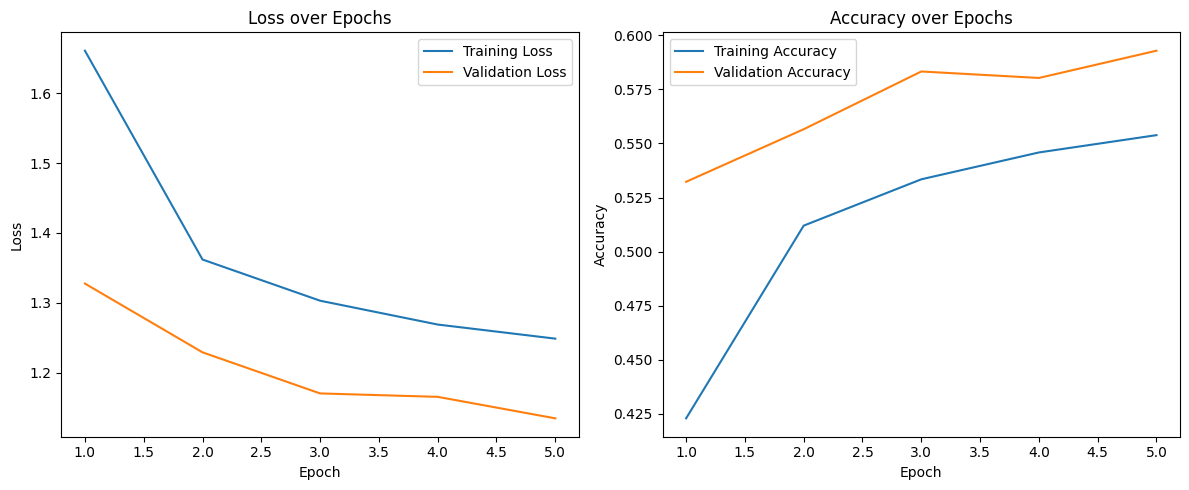

In [ ]:
# To-DO: Plot training and validation loss

### 4️⃣ Model Evaluation and Predictions

Finally, let's evaluate the model on the test set and see some predictions.

In [15]:
test_loss, test_acc = validate_epoch(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 1.1345, Test Accuracy: 0.5929


#### Plot some predictions

Let's get a batch of images from the test set and display them along with their predicted and true labels.

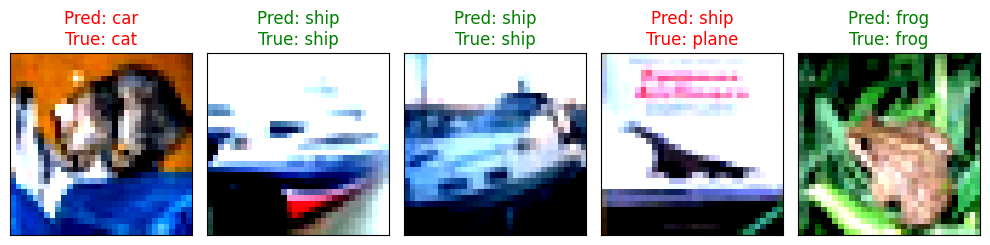

In [ ]:
def plot_predictions(model, dataloader, classes, device, num_images=5):
# To-Do: complete the function

    plt.show()

plot_predictions(model, testloader, classes, device, num_images=5)


## Contributed By: Mohammed Bremoo